<a href="https://colab.research.google.com/github/vidhya2324/Machine_learning/blob/main/YOLO_animal_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from tqdm import tqdm
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
!kaggle datasets download -d antoreepjana/animals-detection-images-dataset

Dataset URL: https://www.kaggle.com/datasets/antoreepjana/animals-detection-images-dataset
License(s): CC0-1.0
100% 8.90G/8.92G [01:42<00:00, 105MB/s]
100% 8.92G/8.92G [01:42<00:00, 93.3MB/s]


In [3]:
data_dir="/content/animals-detection-images-dataset.zip"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

all_train_subdir=glob.glob(train_dir+"/*")
all_test_subdir=glob.glob(test_dir+"/*")

In [5]:
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/Squirrel/013240b8dc5ed267.jpg  
  inflating: train/Squirrel/01998042bc8d9fc5.jpg  
  inflating: train/Squirrel/022a6508667c26a4.jpg  
  inflating: train/Squirrel/029dfca01a8a6c27.jpg  
  inflating: train/Squirrel/02a83d8659c234be.jpg  
  inflating: train/Squirrel/02b3690baaf911b8.jpg  
  inflating: train/Squirrel/02b7b759c7f92d7c.jpg  
  inflating: train/Squirrel/02d71b61109cbe80.jpg  
  inflating: train/Squirrel/0308ef4c641df4e5.jpg  
  inflating: train/Squirrel/031dda839ff54675.jpg  
  inflating: train/Squirrel/0346ada1fdb84d6f.jpg  
  inflating: train/Squirrel/0388c753a05557b1.jpg  
  inflating: train/Squirrel/03b2c9285da59756.jpg  
  inflating: train/Squirrel/03f767d0f5a2057d.jpg  
  inflating: train/Squirrel/04044469eb7c479e.jpg  
  inflating: train/Squirrel/041e5d593d2d4b94.jpg  
  inflating: train/Squirrel/04301655bd17cd90.jpg  
  inflating: train/Squirrel/046675ea134c2256.jpg  
  inflating: train/Squirrel/046

In [6]:
!pip install kaggle

In [7]:
train_dir = "/content/train"
test_dir = "/content/test"

all_train_subdir=glob.glob(train_dir+"/*")
all_test_subdir=glob.glob(test_dir+"/*")

In [8]:
train_classes=[os.path.basename(pp) for pp in all_train_subdir]
test_classes=[os.path.basename(pp) for pp in all_test_subdir]

print("There is %d classes in train dataset, and %d classes in test dataset"%(len(train_classes), len(test_classes)))


There is 80 classes in train dataset, and 80 classes in test dataset


In [9]:
train_classes==test_classes


True

In [10]:
train_image_counts={os.path.basename(pp):[len(glob.glob(os.path.join(pp, "*.jpg")))] for pp in all_train_subdir}
test_image_counts={os.path.basename(pp):[len(glob.glob(os.path.join(pp, "*.jpg")))] for pp in all_test_subdir}
# all_image_counts=train_image_counts.copy()
# all_image_counts={k:all_image_counts[k]+test_image_counts[k] for k in all_image_counts.keys()}
train_data_df = pd.DataFrame(train_image_counts, index=["train"]).transpose()
test_data_df = pd.DataFrame(test_image_counts, index=["test"]).transpose()
all_data_df=train_data_df.copy()
all_data_df["test"]=test_data_df
all_data_df.head()


,train,test
Zebra,181,31
Spider,856,207
Hedgehog,80,49
Woodpecker,171,32
Seahorse,7,33


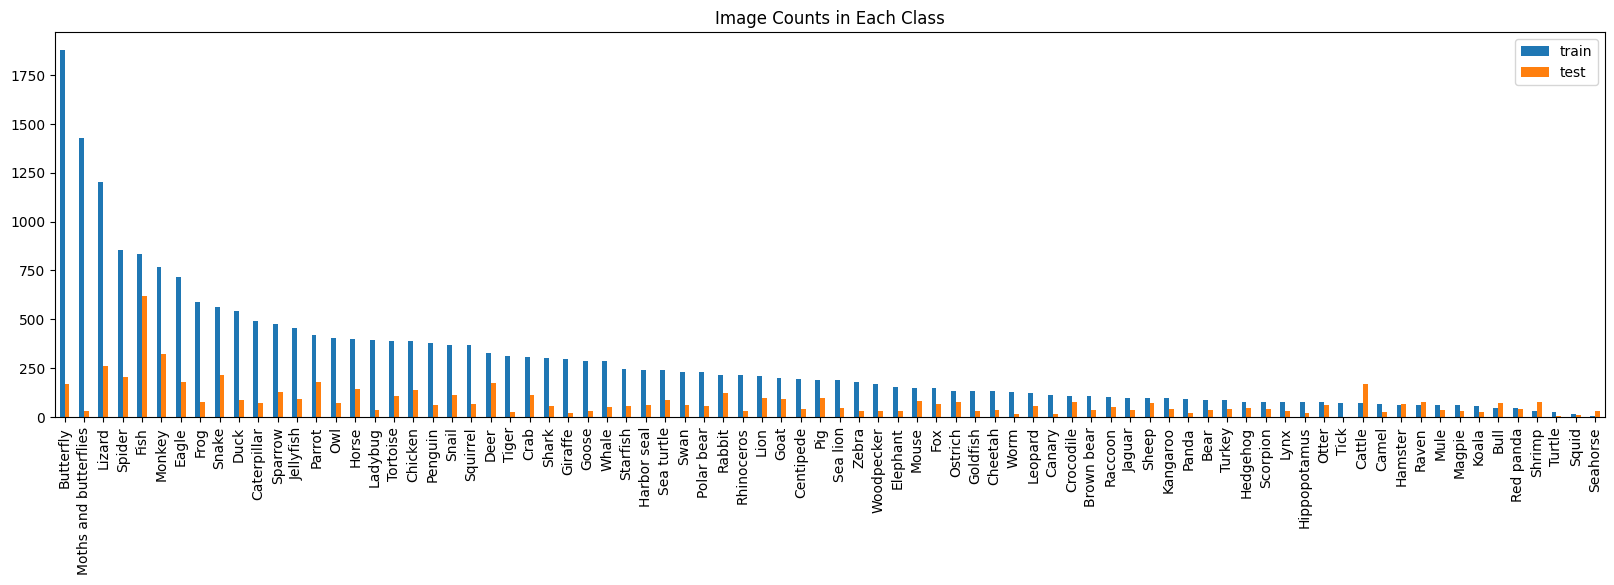

In [11]:
all_data_df=all_data_df.sort_values(by=["train","test"], ascending=False)
all_data_df.plot(kind="bar", legend=True, figsize=(20,5), title="Image Counts in Each Class");


In [12]:
!apt-get install -y file


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
file is already the newest version (1:5.41-3ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [15]:
os.makedirs("output", exist_ok=True)
!file /content/train/Spider/*.jpg|awk '{print $18}'|sort|uniq |wc -l


317


In [17]:
!file /content/test/Spider/*.jpg|awk '{print $18}'|sort|uniq |wc -l


98


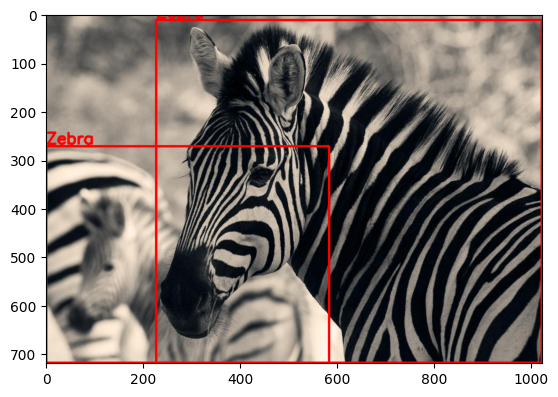

In [18]:
def draw_image(image_file, label_file, class_names):
    class_name = os.path.basename(os.path.dirname(image_file))
    image = cv2.imread(image_file)

    with open(label_file) as fobj:
        while True:
            item = fobj.readline()
            if item is None or len(item)<=0:
                break

            item = item[len(class_name):]
            item = item.split()
            xmin = float(item[0])
            ymin = float(item[1])
            xmax = float(item[2])
            ymax = float(item[3])

            image = cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0,0,255), 3)
            image = cv2.putText(image, class_name, (int(xmin), int(ymin-5)), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 0, 255), 3)

    return image

subdir = all_train_subdir[0]
image_files = glob.glob(os.path.join(subdir, "*.jpg"))

image_file = image_files[0]
label_file = os.path.join(subdir, "Label", os.path.basename(image_file).replace(".jpg", ".txt"))

image = draw_image(image_file, label_file, train_classes)
image = image[:,:,2::-1]
plt.imshow(image);


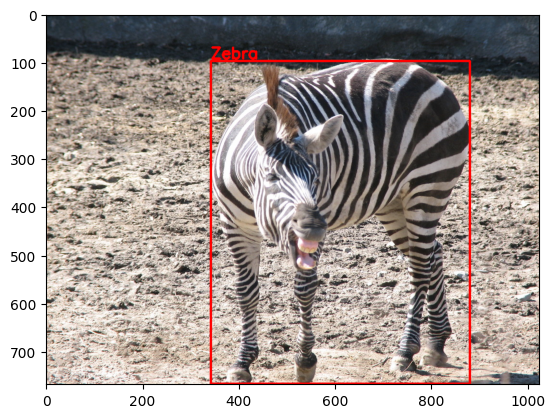

In [19]:
image_file = image_files[45]
label_file = os.path.join(subdir, "Label", os.path.basename(image_file).replace(".jpg", ".txt"))
image = draw_image(image_file, label_file, train_classes)
image = image[:,:,2::-1]
plt.imshow(image);

In [20]:
yolo_train_dir = "yolo/train"
yolo_test_dir = "yolo/test"

for dd in [yolo_train_dir, yolo_test_dir]:
    for ss in ["images", "labels"]:
        print(os.path.join(dd, ss))
        os.makedirs(os.path.join(dd, ss), exist_ok=True)

yolo/train/images
yolo/train/labels
yolo/test/images
yolo/test/labels


In [21]:
yolo_train_dir = "yolo2/train"
yolo_test_dir = "yolo2/test"

for dd in [yolo_train_dir, yolo_test_dir]:
    for ss in ["images", "labels"]:
        print(os.path.join(dd, ss))
        os.makedirs(os.path.join(dd, ss), exist_ok=True)

yolo2/train/images
yolo2/train/labels
yolo2/test/images
yolo2/test/labels


In [22]:
for subdir_id in tqdm(range(len(all_train_subdir))):
    subdir = all_train_subdir[subdir_id]

100%|██████████| 80/80 [00:00<00:00, 317149.64it/s]


In [23]:
"%s_%s"%("hawk","xueqin")


'hawk_xueqin'

In [24]:
def process_dataset(subdirs, dst_dir, class_names, size=(640,640), link=False):
    for subdir_id in tqdm(range(len(subdirs))):
        subdir = subdirs[subdir_id]
        prefix=os.path.basename(subdir)
        for image_file in glob.glob(os.path.join(subdir, "*.jpg")):
            image_file_basename=os.path.basename(image_file)
            label_file = os.path.join(subdir, "Label", image_file_basename).replace(".jpg", ".txt")
            dst_image_file = os.path.join(dst_dir, "images/%s_%s"%(prefix,image_file_basename))
            dst_label_file = os.path.join(dst_dir, "labels/%s_%s"%(prefix,image_file_basename.replace(".jpg", ".txt")))
            if os.path.exists(dst_label_file):
                continue

            image = cv2.imread(image_file)
            height, width = image.shape[0:2]
            with open(label_file) as fobj:
              with open(dst_label_file, "w") as wobj:
                    while True:
                        item = fobj.readline()
                        if item is None or len(item)==0:
                            break
                        class_name = prefix
                        item=item[len(class_name):]
                        item = item.split()
                        xmin = float(item[0])
                        ymin = float(item[1])
                        xmax = float(item[2])
                        ymax = float(item[3])

                        cx   = (xmin + xmax)/2.0/width
                        cy   = (ymin + ymax)/2.0/height
                        bw   = (xmax - xmin)/width
                        bh   = (ymax - ymin)/height
                        class_id = class_names.index(class_name)
                        output_line = "%d %f %f %f %f\n"%(class_id, cx, cy, bw, bh)
                        wobj.write(output_line)

            if link==True:
                os.symlink(image_file, dst_image_file)
            else:
                image = cv2.resize(image, size)
                cv2.imwrite(dst_image_file, image)

# process_dataset(all_train_subdir, yolo_train_dir, train_classes, size=(640,640), link=False)
xueqin_train_subdir=all_train_subdir[0:1]
xueqin_classes=[os.path.basename(pp) for pp in xueqin_train_subdir]

process_dataset(xueqin_train_subdir, yolo_train_dir, xueqin_classes, size=(640,640), link=False)

100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


In [25]:
xueqin_test_subdir=all_test_subdir[0:1]
process_dataset(xueqin_test_subdir, yolo_test_dir, xueqin_classes, size=(640,640), link=False)

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


In [26]:
!pip install einops


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 695.7 kB/s eta 0:00:00


In [27]:
!git clone https://github.com/cmn1565080456/YOLOV5_EMO
%cd YOLOV5_EMO
%pip install -r requirements.txt
%cd -

Cloning into 'YOLOV5_EMO'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 188 (delta 4), reused 4 (delta 0), pack-reused 173
Receiving objects: 100% (188/188), 54.96 MiB | 16.62 MiB/s, done.
Resolving deltas: 100% (45/45), done.
Updating files: 100% (150/150), done.
/content/YOLOV5_EMO
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 315.6 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-ma

In [28]:
!cat YOLOV5_EMO/data/coco128.yaml


# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license
# COCO128 dataset https://www.kaggle.com/ultralytics/coco128 (first 128 images from COCO train2017) by Ultralytics
# Example usage: python train.py --data coco128.yaml
# parent
# ├── yolov5
# └── datasets
#     └── coco128  ← downloads here (7 MB)


# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../datasets/coco128  # dataset root dir
train: images/train2017  # train images (relative to 'path') 128 images
val: images/train2017  # val images (relative to 'path') 128 images
test:  # test images (optional)

# Classes
names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light
  10: fire hydrant
  11: stop sign
  12: parking meter
  13: bench
  14: bird
  15: cat
  16: dog
  17: horse
  18: sheep
  19: cow
  20: elephant
  21: bear
  22: zebra
  23: giraffe
  24: backpack
  25: umbrella
  26: handb

In [29]:
yaml_file="YOLOV5_EMO/data/animal.yaml"
train_images_dir = os.path.join("..", yolo_train_dir, "images")
val_images_dir = os.path.join("..", yolo_test_dir, "images")


names_str=""
for item in xueqin_classes:
    names_str=names_str + ", \'%s\'"%item
names_str= "names: ["+names_str[1:]+"]"

with open(yaml_file, "w") as wobj:
    wobj.write("train: %s\n"%train_images_dir)
    wobj.write("val: %s\n"%val_images_dir)
    wobj.write("nc: %d\n"%len(xueqin_classes))
    wobj.write(names_str+"\n")

In [31]:
!pip install wandb # install the missing module
import wandb
os.environ["WANDB_API_KEY"] = "fc21120c6e24068355da583c3dbaaeac0f13185d"
wandb.login()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.6/303.6 kB 17.9 MB/s eta 0:00:00


wandb: Currently logged in as: dachuang2023 (chuang-da). Use `wandb login --relogin` to force relogin


True

In [36]:
!ls


benchmarks.py	 data	    EMO_5M	LICENSE		  segment	  utils
CITATION.cff	 detect.py  EMO_6M	models		  setup.cfg	  val.py
classify	 EMO_1M     export.py	README.md	  train.py
CONTRIBUTING.md  EMO_2M     hubconf.py	requirements.txt  tutorial.ipynb


In [37]:
!git clone https://github.com/ultralytics/yolov5.git YOLOV5_EMO


Cloning into 'YOLOV5_EMO'...
remote: Enumerating objects: 16824, done.
remote: Total 16824 (delta 0), reused 0 (delta 0), pack-reused 16824
Receiving objects: 100% (16824/16824), 15.54 MiB | 14.69 MiB/s, done.
Resolving deltas: 100% (11538/11538), done.


In [38]:
!pip install -U pip
!pip install -r YOLOV5_EMO/requirements.txt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [39]:
!pip install ultralytics


In [40]:
%cd YOLOV5_EMO


/content/YOLOV5_EMO/YOLOV5_EMO


In [41]:
!bash data/scripts/download_weights.sh


100% 3.87M/3.87M [00:00<00:00, 50.2MB/s]

100% 14.1M/14.1M [00:00<00:00, 111MB/s] 

100% 40.8M/40.8M [00:00<00:00, 176MB/s]

100% 89.3M/89.3M [00:00<00:00, 187MB/s]

100% 166M/166M [00:02<00:00, 79.9MB/s]

100% 6.86M/6.86M [00:00<00:00, 72.2MB/s]

100% 24.8M/24.8M [00:00<00:00, 106MB/s]

100% 69.0M/69.0M [00:00<00:00, 138MB/s]

100% 147M/147M [00:01<00:00, 145MB/s]

100% 270M/270M [00:01<00:00, 195MB/s]

100% 4.87M/4.87M [00:00<00:00, 57.3MB/s]

100% 10.5M/10.5M [00:00<00:00, 90.4MB/s]

100% 24.9M/24.9M [00:00<00:00, 119MB/s]

100% 50.9M/50.9M [00:00<00:00, 164MB/s]

100% 92.0M/92.0M [00:00<00:00, 108MB/s] 

100% 4.11M/4.11M [00:00<00:00, 50.1MB/s]

100% 14.9M/14.9M [00:00<00:00, 120MB/s] 

100% 42.4M/42.4M [00:00<00:00, 205MB/s]

100% 91.9M/91.9M [00:00<00:00, 230MB/s]

100% 170M/170M [00:00<00:00, 188MB/s]



In [42]:
!mv *.pth weights
!ls weights

mv: cannot stat '*.pth': No such file or directory
yolov5l6.pt	yolov5m6.pt	yolov5n6.pt	yolov5s6.pt	yolov5x6.pt
yolov5l-cls.pt	yolov5m-cls.pt	yolov5n-cls.pt	yolov5s-cls.pt	yolov5x-cls.pt
yolov5l.pt	yolov5m.pt	yolov5n.pt	yolov5s.pt	yolov5x.pt
yolov5l-seg.pt	yolov5m-seg.pt	yolov5n-seg.pt	yolov5s-seg.pt	yolov5x-seg.pt


In [50]:
#path: ../datasets/animals  # Path to your dataset
train: "/content/train"
val: "/content/test"
nc = 10  # Number of classes
names = {
  0: 'dog',
  1: 'cat',
  2: 'horse'
}
  # Add more class names as needed


In [55]:
!ls -l runs/detect/animals


ls: cannot access 'runs/detect/animals': No such file or directory


In [51]:
!ls data/


Argoverse.yaml	  GlobalWheat2020.yaml	ImageNet10.yaml  scripts	xView.yaml
coco128-seg.yaml  hyps			ImageNet.yaml	 SKU-110K.yaml
coco128.yaml	  ImageNet1000.yaml	images		 VisDrone.yaml
coco.yaml	  ImageNet100.yaml	Objects365.yaml  VOC.yaml


In [44]:
!pwd


/content/YOLOV5_EMO/YOLOV5_EMO


In [ ]:
!python detect.py --weights runs/train/animals/weights/best.pt --source /kaggle/input/animals-detection-images-dataset/test/Spider/5b9b0b60d04aae25.jpg --name animals --project runs/detect

In [ ]:
!python train.py --data data/VOC.yaml --batch-size 32 --epochs 100 --img-size 640 --project runs/train --name animals --weights weights/yolov5s.pt --device 0